In [ ]:
# import packages
import numpy as np
import pandas as pd
import time
import datetime
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from dateutil.relativedelta import relativedelta

# **Data Processing**

In [ ]:
# download data (S&P 500 last 10 years) from Yahoo Finance
period1 = int(time.mktime((datetime.datetime.now() - relativedelta(years=10)).timetuple()))
period2 = int(time.mktime(datetime.datetime.now().timetuple()))
interval = '1d'
ticker = '^GSPC'
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
df = pd.read_csv(query_string, index_col = 'Date', parse_dates = True)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-12-24,1430.150024,1430.150024,1424.660034,1426.660034,1426.660034,1248960000
2012-12-26,1426.660034,1429.420044,1416.430054,1419.829956,1419.829956,2285030000
2012-12-27,1419.829956,1422.800049,1401.800049,1418.099976,1418.099976,2830180000
2012-12-28,1418.099976,1418.099976,1401.579956,1402.430054,1402.430054,2426680000
2012-12-31,1402.430054,1426.739990,1398.109985,1426.189941,1426.189941,3204330000
...,...,...,...,...,...,...
2022-12-15,3958.370117,3958.370117,3879.449951,3895.750000,3895.750000,4493900000
2022-12-16,3890.909912,3890.909912,3827.909912,3852.360107,3852.360107,7493660000
2022-12-19,3853.790039,3854.860107,3800.040039,3817.659912,3817.659912,3969610000


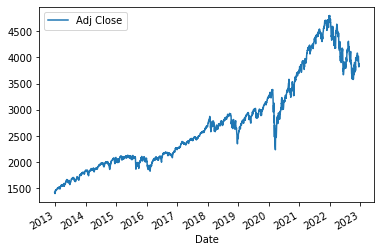

In [ ]:
# preview the dataframe and plot the price chart
df[['Adj Close']].plot()
df

In [ ]:
# see how many samples do we have
df_adjclose = df[['Adj Close']]
print(len(df_adjclose))

2517


In [ ]:
# split data into train set, validation set and test set
train = df_adjclose.iloc[:2017,:]
vali = df_adjclose.iloc[2017:2317,:]
test = df_adjclose.iloc[2317:2517,:]
print(train.shape, vali.shape, test.shape)

(2017, 1) (300, 1) (200, 1)


In [ ]:
# data normalization using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_vali = scaler.fit_transform(vali)
scaled_test = scaler.fit_transform(test)
print(scaled_train.shape, scaled_vali.shape, scaled_test.shape)

(2017, 1) (300, 1) (200, 1)


In [ ]:
# split data into input data set and output data set
n_days = 20 # predict the n_days+1 day's S&P index based on the previous n_days values
def split_data(data, n_days):
  X = []
  Y = []
  for i in range(len(data)):
    predict_day = i+n_days
    if predict_day >= len(data):
      break
    X.append(data[i:predict_day])
    Y.append(data[predict_day])
  return np.array(X), np.array(Y)

X_train, Y_train = split_data(scaled_train, n_days)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(X_train.shape, Y_train.shape)

X_vali, Y_vali = split_data(scaled_vali, n_days)
X_vali = X_vali.reshape(X_vali.shape[0], X_vali.shape[1], 1)
print(X_vali.shape, Y_vali.shape)

X_test, Y_test = split_data(scaled_test, n_days)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_test.shape, Y_test.shape)


(1997, 20, 1) (1997, 1)
(280, 20, 1) (280, 1)
(180, 20, 1) (180, 1)


# Define and Train LSTM Model

In [ ]:
# import packages for LSTM
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# define the LSTM model
model = Sequential()
model.add(LSTM(50, activation = 'relu', input_shape = (X_train.shape[1], 1)))
model.add(Dense(units = 1))
model.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss = 'mse')
model.summary()

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 50)                10400     
                                                                 
 dense_73 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train the LSTM model
n_epochs = 64
model.fit(X_train, Y_train, epochs = n_epochs, batch_size = 8, validation_data = (X_vali, Y_vali), validation_freq =1)

Epoch 1/64
250/250 [==============================] - 39s 12ms/step - loss: 0.0125 - val_loss: 0.0044
Epoch 2/64
250/250 [==============================] - 3s 11ms/step - loss: 4.7855e-04 - val_loss: 0.0037
Epoch 3/64
250/250 [==============================] - 3s 11ms/step - loss: 4.4005e-04 - val_loss: 0.0034
Epoch 4/64
250/250 [==============================] - 3s 11ms/step - loss: 4.0283e-04 - val_loss: 0.0032
Epoch 5/64
250/250 [==============================] - 3s 11ms/step - loss: 3.7047e-04 - val_loss: 0.0030
Epoch 6/64
250/250 [==============================] - 3s 11ms/step - loss: 3.4651e-04 - val_loss: 0.0030
Epoch 7/64
250/250 [==============================] - 3s 11ms/step - loss: 3.3045e-04 - val_loss: 0.0028
Epoch 8/64
250/250 [==============================] - 3s 11ms/step - loss: 3.0757e-04 - val_loss: 0.0025
Epoch 9/64
250/250 [==============================] - 3s 11ms/step - loss: 2.8117e-04 - val_loss: 0.0025
Epoch 10/64
250/250 [==============================] - 3s 

Text(0.5, 0, 'Number of Epochs')

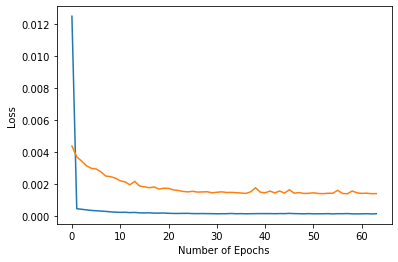

In [ ]:
# keep track of the loss of each epoch and plot the loss
plt.plot(model.history.history['loss']    , label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')

In [ ]:
# use test set to test the model performance
predict_price = model.predict(X_test)
predict_price = scaler.inverse_transform(predict_price)
actual_price = scaler.inverse_transform(Y_test)

6/6 [==============================] - 0s 8ms/step


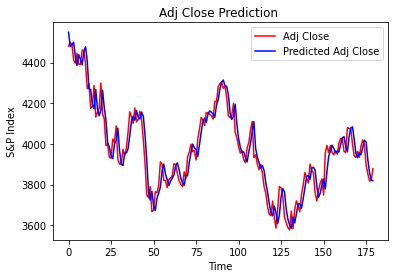

In [ ]:
plt.plot(actual_price, color='red', label='Adj Close')
plt.plot(predict_price, color='blue', label='Predicted Adj Close')
plt.title('Adj Close Prediction ')
plt.xlabel('Time')
plt.ylabel('S&P Index')
plt.legend()
plt.show()

In [ ]:
# use rmse to measure performance
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(actual_price, predict_price))
print(rmse)

65.9113013571463


In [ ]:
# use mape to measure performance
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(actual_price, predict_price)
print(mape)

0.013505933710581688


# Tuning Hyperparameters

### Number of Neurons

In [ ]:
n_neuron = [200, 150, 100, 50, 30, 10]
n_neuron = [10, 30, 50, 100, 150, 200]
rmse_ls = []
mape_ls = []
n_epochs = 10
for i in range(len(n_neuron)):
  print('now number of neurons = {}'.format(n_neuron[i]))
  model = Sequential()
  model.add(LSTM(n_neuron[i], activation = 'relu', input_shape = (X_train.shape[1], 1)))
  model.add(Dense(units = 1))
  model.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss = 'mse')
  model.fit(X_train, Y_train, epochs = n_epochs, batch_size = 8, validation_data = (X_vali, Y_vali), validation_freq =1)
  predict_price = model.predict(X_test)
  predict_price = scaler.inverse_transform(predict_price)
  actual_price = scaler.inverse_transform(Y_test)
  rmse_ls.append(sqrt(mean_squared_error(actual_price, predict_price)))
  mape_ls.append(mean_absolute_percentage_error(actual_price, predict_price))

now number of neurons = 10
Epoch 1/10
250/250 [==============================] - 4s 10ms/step - loss: 0.0411 - val_loss: 0.0063
Epoch 2/10
250/250 [==============================] - 2s 10ms/step - loss: 8.0433e-04 - val_loss: 0.0058
Epoch 3/10
250/250 [==============================] - 2s 9ms/step - loss: 7.2149e-04 - val_loss: 0.0053
Epoch 4/10
250/250 [==============================] - 2s 9ms/step - loss: 6.1095e-04 - val_loss: 0.0049
Epoch 5/10
250/250 [==============================] - 2s 9ms/step - loss: 5.3453e-04 - val_loss: 0.0043
Epoch 6/10
250/250 [==============================] - 2s 9ms/step - loss: 4.6838e-04 - val_loss: 0.0041
Epoch 7/10
250/250 [==============================] - 2s 9ms/step - loss: 4.4867e-04 - val_loss: 0.0039
Epoch 8/10
250/250 [==============================] - 2s 9ms/step - loss: 4.3064e-04 - val_loss: 0.0037
Epoch 9/10
250/250 [==============================] - 2s 9ms/step - loss: 4.1803e-04 - val_loss: 0.0035
Epoch 10/10
6/6 [======================

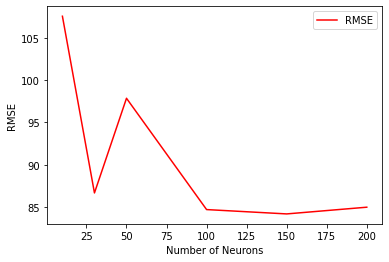

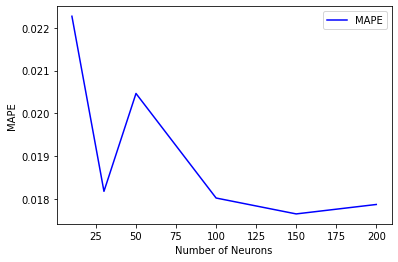

In [ ]:
plt.plot(n_neuron, rmse_ls, color='red', label='RMSE')
plt.xlabel('Number of Neurons')
plt.ylabel('RMSE')
plt.legend()
plt.show()

plt.plot(n_neuron, mape_ls, color='blue', label='MAPE')
plt.xlabel('Number of Neurons')
plt.ylabel('MAPE')
plt.legend()
plt.show()

###Number of Epochs

In [ ]:
n_epoch = [10, 20, 30, 40, 50, 60]
rmse_ls = []
mape_ls = []
for i in range(len(n_epoch)):
  print('now number of epochs = {}'.format(n_epoch[i]))
  model = Sequential()
  model.add(LSTM(200, activation = 'relu', input_shape = (X_train.shape[1], 1)))
  model.add(Dense(units = 1))
  model.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss = 'mse')
  model.fit(X_train, Y_train, epochs = n_epoch[i], batch_size = 8, validation_data = (X_vali, Y_vali), validation_freq =1)
  predict_price = model.predict(X_test)
  predict_price = scaler.inverse_transform(predict_price)
  actual_price = scaler.inverse_transform(Y_test)
  rmse_ls.append(sqrt(mean_squared_error(actual_price, predict_price)))
  mape_ls.append(mean_absolute_percentage_error(actual_price, predict_price))

now number of epochs = 10
Epoch 1/10
250/250 [==============================] - 11s 37ms/step - loss: 0.0082 - val_loss: 0.0044
Epoch 2/10
250/250 [==============================] - 9s 37ms/step - loss: 6.3925e-04 - val_loss: 0.0041
Epoch 3/10
250/250 [==============================] - 9s 37ms/step - loss: 5.1004e-04 - val_loss: 0.0035
Epoch 4/10
250/250 [==============================] - 9s 37ms/step - loss: 4.5292e-04 - val_loss: 0.0039
Epoch 5/10
250/250 [==============================] - 9s 37ms/step - loss: 3.8991e-04 - val_loss: 0.0030
Epoch 6/10
250/250 [==============================] - 9s 37ms/step - loss: 4.1509e-04 - val_loss: 0.0028
Epoch 7/10
250/250 [==============================] - 9s 37ms/step - loss: 3.4308e-04 - val_loss: 0.0026
Epoch 8/10
250/250 [==============================] - 9s 37ms/step - loss: 3.1837e-04 - val_loss: 0.0026
Epoch 9/10
250/250 [==============================] - 9s 36ms/step - loss: 3.2952e-04 - val_loss: 0.0030
Epoch 10/10
6/6 [===============

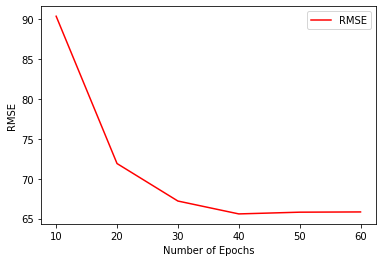

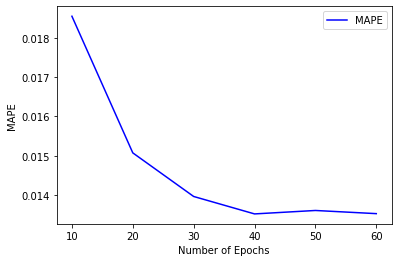

In [ ]:
plt.plot(n_epoch, rmse_ls, color='red', label='RMSE')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

plt.plot(n_epoch, mape_ls, color='blue', label='MAPE')
plt.xlabel('Number of Epochs')
plt.ylabel('MAPE')
plt.legend()
plt.show()

###Batch Size

In [ ]:
n_epoch = 40
batch_size = [4, 8, 16, 64]
rmse_ls = []
mape_ls = []
for i in range(len(batch_size)):
  print('now batch size = {}'.format(batch_size[i]))
  model = Sequential()
  model.add(LSTM(200, activation = 'relu', input_shape = (X_train.shape[1], 1)))
  model.add(Dense(units = 1))
  model.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss = 'mse')
  model.fit(X_train, Y_train, epochs = n_epoch, batch_size = batch_size[i], validation_data = (X_vali, Y_vali), validation_freq =1)
  predict_price = model.predict(X_test)
  predict_price = scaler.inverse_transform(predict_price)
  actual_price = scaler.inverse_transform(Y_test)
  rmse_ls.append(sqrt(mean_squared_error(actual_price, predict_price)))
  mape_ls.append(mean_absolute_percentage_error(actual_price, predict_price))

now batch size = 4
Epoch 1/40
500/500 [==============================] - 16s 30ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 2/40
500/500 [==============================] - 15s 30ms/step - loss: 5.6264e-04 - val_loss: 0.0034
Epoch 3/40
500/500 [==============================] - 18s 37ms/step - loss: 6.1439e-04 - val_loss: 0.0029
Epoch 4/40
500/500 [==============================] - 15s 30ms/step - loss: 3.9372e-04 - val_loss: 0.0030
Epoch 5/40
500/500 [==============================] - 15s 30ms/step - loss: 3.5154e-04 - val_loss: 0.0026
Epoch 6/40
500/500 [==============================] - 15s 29ms/step - loss: 3.1323e-04 - val_loss: 0.0029
Epoch 7/40
500/500 [==============================] - 15s 30ms/step - loss: 2.6434e-04 - val_loss: 0.0020
Epoch 8/40
500/500 [==============================] - 15s 30ms/step - loss: 2.7354e-04 - val_loss: 0.0020
Epoch 9/40
500/500 [==============================] - 15s 30ms/step - loss: 2.4227e-04 - val_loss: 0.0020
Epoch 10/40
500/500 [==========

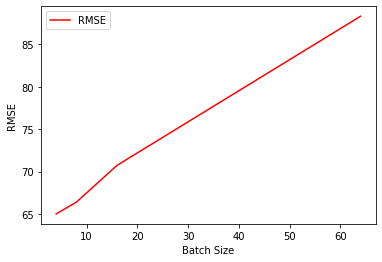

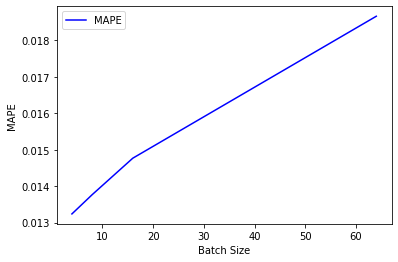

In [ ]:
plt.plot(batch_size, rmse_ls, color='red', label='RMSE')
plt.xlabel('Batch Size')
plt.ylabel('RMSE')
plt.legend()
plt.show()

plt.plot(batch_size, mape_ls, color='blue', label='MAPE')
plt.xlabel('Batch Size')
plt.ylabel('MAPE')
plt.legend()
plt.show()